In [ ]:
# Import necessary libraries
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the weather dataset
dataset_path = '/content/drive/My Drive/MMU/Assignments/HPC/weather.csv'

# Verify if the file exists
import os

if os.path.exists(dataset_path):
    print(f"Dataset found at: {dataset_path}")
else:
    print(f"Error: Dataset not found at {dataset_path}. Please check the path.")

Dataset found at: /content/drive/My Drive/MMU/Assignments/HPC/weather.csv


In [ ]:
import pandas as pd

# Path to the weather CSV file
csv_path = '/content/drive/My Drive/MMU/Assignments/HPC/weather.csv'

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
    timestamp  sensor_id  Location  temperature  humidity  wind_speed  \
0   11/8/2024          1  New York           19        14          38   
1  10/10/2024          2     Dubai           -6        37          46   
2   8/14/2024          3     Tokyo            1        94          35   
3   9/11/2024          4   Beijing           28        78          25   
4    6/6/2024          5     Paris           31        81          43   

   precipitation  air_pressure  uv_index  air_quality  
0             12           965         7          182  
1             41           964         7          377  
2              2          1090         9          127  
3              3           938         0          360  
4             27          1042         6           74  


In [ ]:
!pip install confluent_kafka

In [ ]:
from confluent_kafka import Producer, Consumer, KafkaException, KafkaError
print("Successfully imported confluent_kafka!")

Successfully imported confluent_kafka!


# **Kafka Producer**

In [ ]:
import pandas as pd
from confluent_kafka import Producer, KafkaException

# Confluent Cloud configuration
KAFKA_CONFIG = {
    'bootstrap.servers': 'pkc-l6wr6.europe-west2.gcp.confluent.cloud:9092',  # Replace with your Bootstrap Server
    'sasl.mechanisms': 'PLAIN',
    'security.protocol': 'SASL_SSL',
    'sasl.username': 'HMKDYMRMBGJHNZKU',  # Replace with your API Key
    'sasl.password': 'Opy3nE6vyDZuS2jqI13tMaxi8WaLfOGQkhQD86qNTEU0O1i4T5s07WvbFv7aAUG0',  # Replace with your API Secret
}

TOPIC = "weather_data"  # Kafka topic for weather data

# Path to the weather CSV file
csv_path = '/content/drive/My Drive/MMU/Assignments/HPC/weather.csv'

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# # Display the first few rows of the DataFrame
# print("First few rows of the dataset:")
# print(df.head())

# Initialize Kafka Producer
producer = Producer(KAFKA_CONFIG)

# Produce weather data to Kafka
print(f"Producing weather data to Kafka topic: {TOPIC}...")
for index, row in df.iterrows():
    # Convert the row to a string to send as a Kafka message
    message = row.to_json()  # Convert row to JSON format
    try:
        producer.produce(TOPIC, key=None, value=message)
        print(f"Produced record {index}: {message}")
    except KafkaException as e:
        print(f"Error while producing message: {e}")

# Ensure all messages are sent
producer.flush()
print("All weather data has been produced to Kafka.")

Producing weather data to Kafka topic: weather_data...
Produced record 0: {"timestamp":"11\/8\/2024","sensor_id":1,"Location":"New York","temperature":19,"humidity":14,"wind_speed":38,"precipitation":12,"air_pressure":965,"uv_index":7,"air_quality":182}
Produced record 1: {"timestamp":"10\/10\/2024","sensor_id":2,"Location":"Dubai","temperature":-6,"humidity":37,"wind_speed":46,"precipitation":41,"air_pressure":964,"uv_index":7,"air_quality":377}
Produced record 2: {"timestamp":"8\/14\/2024","sensor_id":3,"Location":"Tokyo","temperature":1,"humidity":94,"wind_speed":35,"precipitation":2,"air_pressure":1090,"uv_index":9,"air_quality":127}
Produced record 3: {"timestamp":"9\/11\/2024","sensor_id":4,"Location":"Beijing","temperature":28,"humidity":78,"wind_speed":25,"precipitation":3,"air_pressure":938,"uv_index":0,"air_quality":360}
Produced record 4: {"timestamp":"6\/6\/2024","sensor_id":5,"Location":"Paris","temperature":31,"humidity":81,"wind_speed":43,"precipitation":27,"air_pressure

In [ ]:
from confluent_kafka import Consumer, KafkaException
import json
import sys

# Confluent Cloud Kafka configuration
KAFKA_CONFIG = {
    'bootstrap.servers': 'pkc-l6wr6.europe-west2.gcp.confluent.cloud:9092',
    'sasl.mechanisms': 'PLAIN',
    'security.protocol': 'SASL_SSL',
    'sasl.username': 'HMKDYMRMBGJHNZKU',  # Replace with your API Key
    'sasl.password': 'Opy3nE6vyDZuS2jqI13tMaxi8WaLfOGQkhQD86qNTEU0O1i4T5s07WvbFv7aAUG0',  # Replace with your API Secret
    'group.id': 'weather-consumer-group',  # Consumer group ID
    'auto.offset.reset': 'earliest'  # Start from the beginning of the topic
}

TOPIC = "weather_data"

# Initialize the Consumer
consumer = Consumer(KAFKA_CONFIG)

# Subscribe to the topic
consumer.subscribe([TOPIC])

print(f"Subscribed to topic: {TOPIC}")
print("Consuming messages... Press Ctrl+C to exit.\n")

try:
    while True:
        msg = consumer.poll(1.0)  # Poll for new messages (timeout = 1 second)

        if msg is None:
            continue
        if msg.error():
            print(f"Consumer error: {msg.error()}")
            continue

        # Decode the message value (bytes to JSON)
        message_value = msg.value().decode('utf-8')
        weather_data = json.loads(message_value)

        print(f"Received message: {weather_data}")

except KeyboardInterrupt:
    print("\nShutting down consumer...")

finally:
    # Close the consumer to commit final offsets and leave group
    consumer.close()


Subscribed to topic: weather_data
Consuming messages... Press Ctrl+C to exit.

Received message: {'timestamp': '11/8/2024', 'sensor_id': 1, 'Location': 'New York', 'temperature': 19, 'humidity': 14, 'wind_speed': 38, 'precipitation': 12, 'air_pressure': 965, 'uv_index': 7, 'air_quality': 182}
Received message: {'timestamp': '10/10/2024', 'sensor_id': 2, 'Location': 'Dubai', 'temperature': -6, 'humidity': 37, 'wind_speed': 46, 'precipitation': 41, 'air_pressure': 964, 'uv_index': 7, 'air_quality': 377}
Received message: {'timestamp': '8/14/2024', 'sensor_id': 3, 'Location': 'Tokyo', 'temperature': 1, 'humidity': 94, 'wind_speed': 35, 'precipitation': 2, 'air_pressure': 1090, 'uv_index': 9, 'air_quality': 127}
Received message: {'timestamp': '9/11/2024', 'sensor_id': 4, 'Location': 'Beijing', 'temperature': 28, 'humidity': 78, 'wind_speed': 25, 'precipitation': 3, 'air_pressure': 938, 'uv_index': 0, 'air_quality': 360}
Received message: {'timestamp': '6/6/2024', 'sensor_id': 5, 'Location

# **downloads the Spark 3.3.2 binary distribution (with Hadoop 3 support) from the Apache archive server**

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xzf spark-3.3.2-bin-hadoop3.tgz


--2025-05-16 07:20:28--  https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz.2’

spark-3.3.2-bin-had 100%[===================>] 285.49M  2.39MB/s    in 1m 58s  

2025-05-16 07:22:27 (2.41 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz.2’ saved [299360284/299360284]



In [ ]:
# uninstalling the dataproc
!pip uninstall -y dataproc-spark-connect


In [ ]:
 # Install the correct PySpark and findspark Python packages:
!pip install -q pyspark==3.3.2 findspark --force-reinstall


In [ ]:
# Check PySpark version to confirm:
import pyspark
print("PySpark version:", pyspark.__version__)


PySpark version: 3.3.2


In [ ]:
# Set environment variables and initialize Spark:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
os.environ["PATH"] += ":/content/spark-3.3.2-bin-hadoop3/bin"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("KafkaSparkETL") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"✅ Spark Session created - version: {spark.version}")


✅ Spark Session created - version: 3.3.2


In [ ]:
# install netcap
!apt-get install -y netcat
!nc -zv pkc-l6wr6.europe-west2.gcp.confluent.cloud 9092


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  netcat-openbsd
The following NEW packages will be installed:
  netcat netcat-openbsd
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 41.4 kB of archives.
After this operation, 126 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 netcat-openbsd amd64 1.218-4ubuntu1 [39.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 netcat all 1.218-4ubuntu1 [2,044 B]
Fetched 41.4 kB in 0s (182 kB/s)
Selecting previously unselected package netcat-openbsd.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../netcat-openbsd_1.218-4ubuntu1_amd64.deb ...
Unpacking netcat-openbsd (1.218-4ubuntu1) ...
Selecting previously unselected package netcat.
Preparing to unpack .../netcat_1.218-4ubuntu1_all.deb ...
Unpacking netcat (

# **Spark**

***Part 1: Basic Spark and Kafka Integration***

In [ ]:
import time
from pyspark.sql import SparkSession

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Kafka Basic Read Test") \
    .getOrCreate()

# Step 2: Read Data from Kafka
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "pkc-l6wr6.europe-west2.gcp.confluent.cloud:9092") \
    .option("subscribe", "weather_data") \
    .option("startingOffsets", "earliest") \
    .option("kafka.sasl.mechanism", "PLAIN") \
    .option("kafka.security.protocol", "SASL_SSL") \
    .option("kafka.sasl.jaas.config", "org.apache.kafka.common.security.plain.PlainLoginModule required username='HMKDYMRMBGJHNZKU' password='Opy3nE6vyDZuS2jqI13tMaxi8WaLfOGQkhQD86qNTEU0O1i4T5s07WvbFv7aAUG0';") \
    .load()

# Step 3: Write Raw Kafka Data to Console
query = df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

# Step 4: Programmatically Stop the Query After 60 Seconds
timeout_seconds = 60  # Set timeout duration
start_time = time.time()

while query.isActive:
    if time.time() - start_time > timeout_seconds:
        query.stop()
        print(f"Query terminated after {timeout_seconds} seconds.")
        break
    time.sleep(1)  # Check every 1 second

Query terminated after 60 seconds.


***Part 2: Parsing JSON Data***

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import time

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Kafka Weather Data Streaming") \
    .getOrCreate()

# Step 2: Define Schema for Weather Data
schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("sensor_id", IntegerType(), True),
    StructField("Location", StringType(), True),
    StructField("temperature", IntegerType(), True),
    StructField("humidity", IntegerType(), True),
    StructField("wind_speed", IntegerType(), True),
    StructField("precipitation", IntegerType(), True),
    StructField("air_pressure", IntegerType(), True),
    StructField("uv_index", IntegerType(), True),
    StructField("air_quality", IntegerType(), True)
])

# Step 3: Read Data from Kafka
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "pkc-l6wr6.europe-west2.gcp.confluent.cloud:9092") \
    .option("subscribe", "weather_data") \
    .option("startingOffsets", "earliest") \
    .option("kafka.sasl.mechanism", "PLAIN") \
    .option("kafka.security.protocol", "SASL_SSL") \
    .option("kafka.sasl.jaas.config", "org.apache.kafka.common.security.plain.PlainLoginModule required username='HMKDYMRMBGJHNZKU' password='Opy3nE6vyDZuS2jqI13tMaxi8WaLfOGQkhQD86qNTEU0O1i4T5s07WvbFv7aAUG0';") \
    .load()

# Debug Step 1: Log Raw Kafka Data to Console
df.selectExpr("CAST(value AS STRING) AS raw_value").writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

# Step 4: Parse JSON Data
parsed_df = df.selectExpr("CAST(value AS STRING)") \
    .select(from_json(col("value"), schema).alias("data")) \
    .select("data.*")

# Debug Step 2: Log Parsed Data to Console
parsed_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

# Step 5: Write Parsed Data to Console (Final Output)
query = parsed_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

# Step 6: Monitor and Stop the Query After Timeout
timeout_seconds = 60  # Set timeout duration in seconds
start_time = time.time()

while query.isActive:
    if time.time() - start_time > timeout_seconds:
        query.stop()
        print(f"Query terminated after {timeout_seconds} seconds.")
        break
    time.sleep(1)  # Check the status every 1 second

print("Streaming job completed.")

Query terminated after 60 seconds.
Streaming job completed.


***Spark Streaming Aggregation with Auto-Termination***

In [ ]:
from pyspark.sql.functions import avg
from threading import Timer

# Step 1: Perform Aggregation
def process_batch(df, epoch_id):
    print(f"Processing batch {epoch_id}...")
    df.show()  # Print the result
    # Optional: Save to sink (like DB, file, etc.)

    # Stop query after 1st batch (simulate)
    if epoch_id == 0:  # Example condition to stop after the first batch
        print("Stopping query after first batch...")
        Timer(5, lambda: query.stop()).start()  # Stop after 5 seconds

average_temperature = parsed_df.groupBy("Location") \
    .agg(avg("temperature").alias("avg_temperature"))

# Step 2: Write using foreachBatch and simulate stopping
query = average_temperature.writeStream \
    .outputMode("complete") \
    .foreachBatch(process_batch) \
    .start()

query.awaitTermination()

Processing batch 0...
+-----------+------------------+
|   Location|   avg_temperature|
+-----------+------------------+
|    Beijing|              8.82|
|Los Angeles|12.602150537634408|
|     London|10.766990291262136|
|     Mumbai|             7.375|
|      Tokyo|          12.71875|
|     Sydney| 9.028571428571428|
|      Paris|10.162162162162161|
|       Rome| 9.943396226415095|
|      Dubai| 5.095238095238095|
|   New York|10.561224489795919|
+-----------+------------------+

Stopping query after first batch...


# **Load Transformed Data to Google Drive [as Parquet or CSV] (Hadoop Alternative)**

In [ ]:
def write_to_parquet(batch_df, batch_id):
    batch_df.write.mode("overwrite").parquet(output_path)

query = average_temperature.writeStream \
    .outputMode("complete") \
    .foreachBatch(write_to_parquet) \
    .option("checkpointLocation", "/content/drive/My Drive/MMU/Assignments/HPC/output/checkpoint") \
    .trigger(once=True) \
    .start()

query.awaitTermination()
print("✅ Load step completed. Aggregated data written to Google Drive.")


✅ Load step completed. Aggregated data written to Google Drive.


# ***Machine Learning Task using - Spark MLib***

In [ ]:
# Step 0: Imports and Spark session assumed initialized as `spark`
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt


# Step 1: Define Schema for Incoming Kafka JSON Data

We define the expected schema of the JSON messages coming from Kafka.  
Each message contains:  
- location (string)  
- temperature (double)  
- humidity (double)


In [ ]:
schema = StructType([
    StructField("location", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("humidity", DoubleType(), True)
])


# Step 2: Parse Kafka Stream and Extract Data Fields

- Kafka data arrives in a column named `value` as binary.  
- Cast it to string, then parse JSON using the defined schema.  
- Select the parsed fields for further processing.


In [ ]:
df_json = df.selectExpr("CAST(value AS STRING) AS json_str") \
            .select(from_json(col("json_str"), schema).alias("data")) \
            .select("data.*")

df_json.printSchema()  # Check schema


root
 |-- location: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)



# Step 3: Write Parsed Stream to Parquet with Checkpointing

- We write the parsed streaming data into Parquet files to enable batch processing downstream.  
- Checkpointing ensures fault tolerance and state recovery.


In [ ]:
query = df_json.writeStream \
    .format("parquet") \
    .option("checkpointLocation", "/tmp/checkpoint") \
    .option("path", "/tmp/kafka_output") \
    .start()


# Step 4: Read Batch Data from Parquet for Clustering

- Once streaming data is saved as parquet, read the data back as static batch DataFrame for ML processing.  
- This step simulates batch model training or prediction on streaming data snapshots.


In [ ]:
batch_df = spark.read.parquet("/tmp/kafka_output")
batch_df.show(5)


+--------+-----------+--------+
|location|temperature|humidity|
+--------+-----------+--------+
|    null|       19.0|    14.0|
|    null|       -6.0|    37.0|
|    null|        1.0|    94.0|
|    null|       28.0|    78.0|
|    null|       31.0|    81.0|
+--------+-----------+--------+
only showing top 5 rows



# Step 5: Assemble Features for ML Model

- Use VectorAssembler to combine `temperature` and `humidity` into a single feature vector column named `features`.


In [ ]:
assembler = VectorAssembler(
    inputCols=["temperature", "humidity"],
    outputCol="features"
)

data_with_features = assembler.transform(batch_df)


# Step 6: Train KMeans Clustering Model

- Use KMeans to cluster the data into 3 clusters (`k=3`).  
- Set random seed for reproducibility.


In [ ]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(data_with_features.select("features"))


# Step 7: Predict Cluster Assignments

- Use the trained model to assign each data point to a cluster.  
- Results will include original columns plus a `prediction` column indicating cluster membership.


In [ ]:
predictions = model.transform(data_with_features)
predictions.select("location", "temperature", "humidity", "prediction").show()


+--------+-----------+--------+----------+
|location|temperature|humidity|prediction|
+--------+-----------+--------+----------+
|    null|       19.0|    14.0|         1|
|    null|       -6.0|    37.0|         2|
|    null|        1.0|    94.0|         0|
|    null|       28.0|    78.0|         0|
|    null|       31.0|    81.0|         0|
|    null|       36.0|    53.0|         0|
|    null|        2.0|    31.0|         1|
|    null|       -2.0|    22.0|         1|
|    null|       14.0|    44.0|         2|
|    null|       -2.0|    67.0|         2|
|    null|      -13.0|    41.0|         2|
|    null|      -19.0|    68.0|         2|
|    null|       -9.0|    70.0|         2|
|    null|        9.0|     5.0|         1|
|    null|      -11.0|    10.0|         1|
|    null|       13.0|    95.0|         0|
|    null|       14.0|    77.0|         0|
|    null|        1.0|    17.0|         1|
|    null|       -6.0|    32.0|         2|
|    null|       14.0|     3.0|         1|
+--------+-

# Step 8: Visualize Clusters

- Convert Spark DataFrame to Pandas for plotting.  
- Create a scatter plot with temperature on x-axis, humidity on y-axis, colored by cluster assignment.


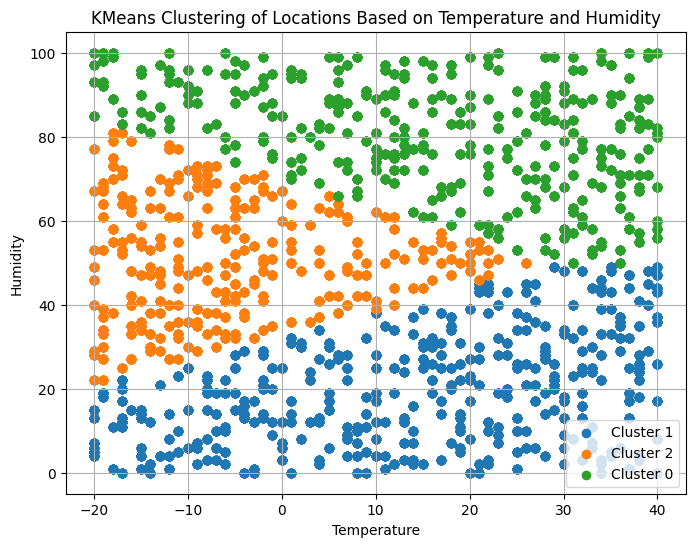

In [ ]:
pandas_df = predictions.select("temperature", "humidity", "prediction").toPandas()

plt.figure(figsize=(8, 6))
for cluster in pandas_df["prediction"].unique():
    cluster_data = pandas_df[pandas_df["prediction"] == cluster]
    plt.scatter(cluster_data["temperature"], cluster_data["humidity"], label=f"Cluster {cluster}")

plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.title("KMeans Clustering of Locations Based on Temperature and Humidity")
plt.legend()
plt.grid(True)
plt.show()
